In [1]:
import os
import numpy as np
from imageio.v2 import imread
import imreg_dft as ird
import matplotlib.pyplot as plt
import imreg_dft as ird
from PIL import Image
from skimage.exposure import equalize_adapthist, rescale_intensity
from skimage.transform import resize
from skimage import img_as_ubyte
basedir = os.path.join('/Users/linh/Downloads/example-toy-images-for-registration/', 'data')
%matplotlib inline

In [2]:
def rgb2gray(rgb_image):
    # Use the standard NTSC conversion formula
    return np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])

def contrast_stretching(img):
    img = img.astype(np.float32)
    p1 = np.percentile(img, 1)
    p99 = np.percentile(img, 99)
    res_img = rescale_intensity(img, in_range=(p1, p99), out_range=(0, 1))
    return res_img

def eq_adaphist(img):
    img = img.astype(np.float32)
    img = np.clip(img,
                  a_min=np.mean(img) - 5 * np.std(img),
                  a_max=np.mean(img) + 5 * np.std(img)
                  )
    eq_img = equalize_adapthist(img / img.max())
    return eq_img

def register(img0: np.ndarray, 
             img1: np.ndarray, 
             method: str = "similarity", 
             numiter: int = 10,
             preprocess_method: str = None,
             constraints: dict = None):
    if preprocess_method == None:
        pass
    elif preprocess_method == "equalize_adapthist":
        img0 = eq_adaphist(img0)
        img1 = eq_adaphist(img1)
    else:
        img0 = contrast_stretching(img0)
        img1 = contrast_stretching(img1)
    
    if constraints is None:
        constraints = {} # Default to no constraints if none provided

    if method == "translation":
        result = ird.translation(img0, img1) # does't allow to use "numiter"
        result["scale"] = 0
    elif method == "similarity":
        result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
    else:
        raise ValueError(f"Unsupported registration method: {method}")
        

    # Extracting transformation parameters from the result
     # Post-process results
    # Note: You might need to adjust these lines based on the actual result structure
    # especially if 'result' does not include 'tvec', 'angle', 'scale', 'success' directly.
    x = round(result.get("tvec")[1], 4)
    y = round(result.get("tvec")[0], 4)
    angle = round(result.get("angle"), 4)
    scale = round(result.get("scale"), 4)
    success = round(result.get("success"), 4)

    # Ensure to include 'timg' if it's part of the result from ird.similarity
    return {
        "x": x,
        "y": y,
        "angle": angle,
        "scale": scale,
        "success": success,
        "timg": result.get('timg')  # This line assumes 'timg' is a key in the result
    }

In [3]:
def register(img0: np.ndarray, 
             img1: np.ndarray, 
             method: str = "similarity", 
             numiter: int = 10,
             preprocess_method: str = None,
             constraints: dict = None):
    if preprocess_method == None:
        pass
    elif preprocess_method == "equalize_adapthist":
        img0 = eq_adaphist(img0)
        img1 = eq_adaphist(img1)
    else:
        img0 = contrast_stretching(img0)
        img1 = contrast_stretching(img1)
    
    if constraints is None:
        constraints = {} # Default to no constraints if none provided
    if method == "translation":
        # Assuming 'ird.translation' returns a result similar to 'ird.similarity'
        # Adjust this call according to the actual return structure of ird.translation
        result = ird.translation(img0, img1)
        # Ensure 'tvec' is extracted correctly from 'result'
        # Note: This step depends on the actual structure of the 'result' from ird.translation
        tvec = result.get("tvec")
        if tvec is None:
            raise KeyError("Translation result does not include 'tvec'")
        # Include any other necessary transformation parameters
        x, y = tvec
    elif method == "similarity":
        result = ird.similarity(img0, img1, numiter=numiter, constraints=constraints)
        # Extract transformation parameters
        x, y = result.get("tvec", [None, None])
        angle = result.get("angle")
        scale = result.get("scale")
        success = result.get("success")
        # Ensure to handle 'timg' if it's part of the result
        timg = result.get('timg')
    else:
        raise ValueError(f"Unsupported registration method: '{method}'")

    # Compile and return the result dictionary
    return_dict = {
        "x": round(x, 4),
        "y": round(y, 4),
        "tvec": np.array([x, y]).round(4),  # Example of how to include 'tvec'
    }
    
    if method == "similarity":
        return_dict.update({
            "angle": round(angle, 4),
            "scale": round(scale, 4),
            "success": round(success, 4),
            "timg": timg  # Assuming 'timg' is a key in the result
        })
    
    return return_dict

## Show the Target Image

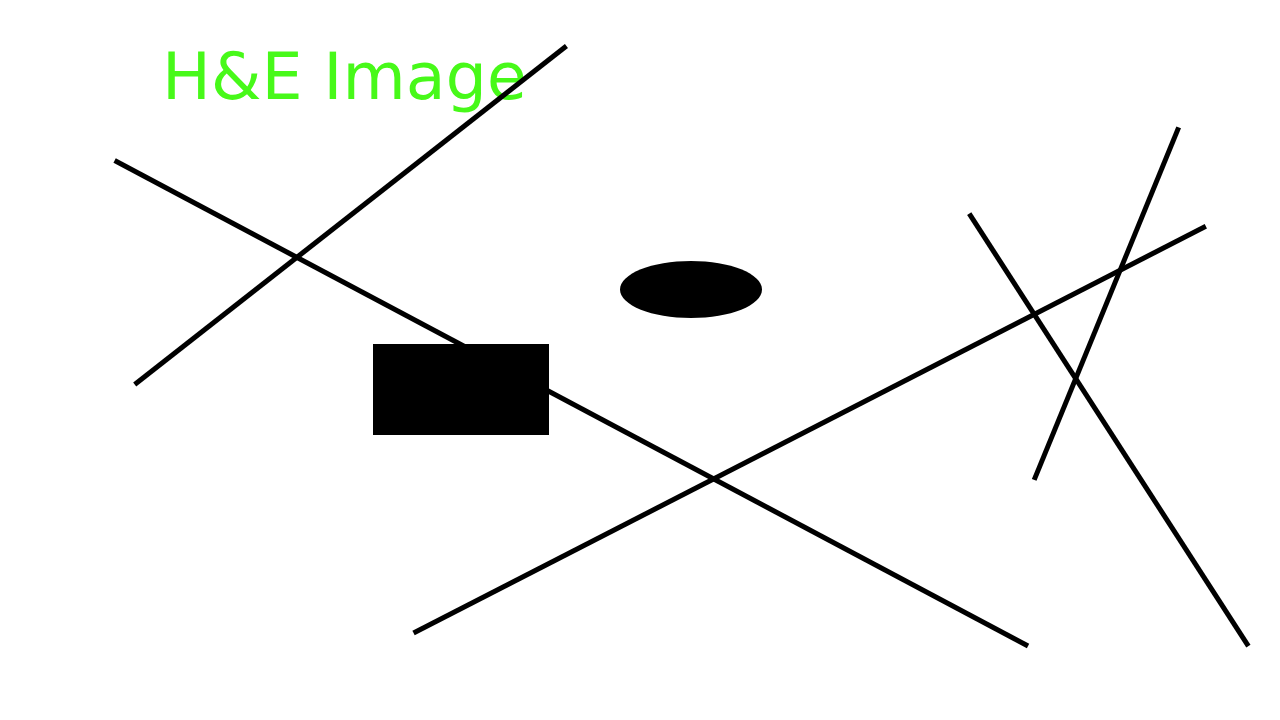

In [168]:
tag = Image.open(os.path.join(basedir, "image-target-image.png"))
# tag.show()
display(tag)

## Show the simple image 1

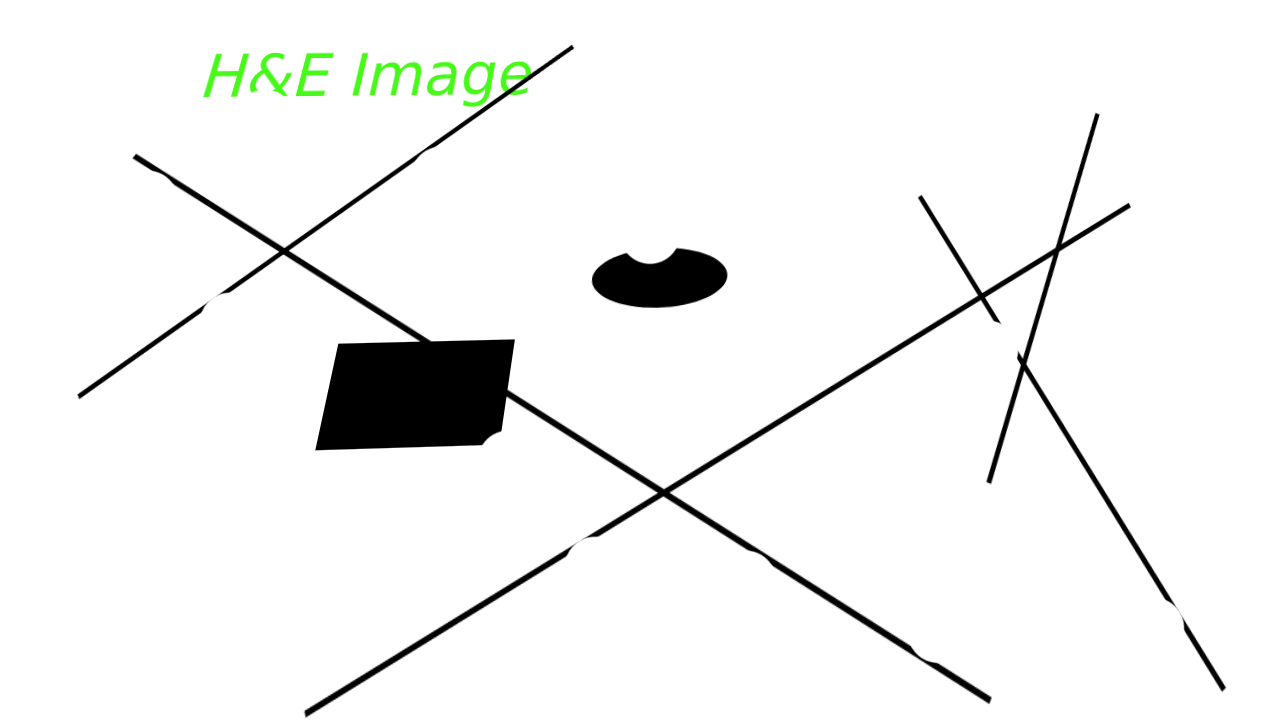

In [169]:
tag = Image.open(os.path.join(basedir, "tiled/image-simple-1.png"))
# tag.show()
display(tag)

## Registration using the "Similarity" method
### First, using the simple image to register with the target one

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (720, 1280, 4)


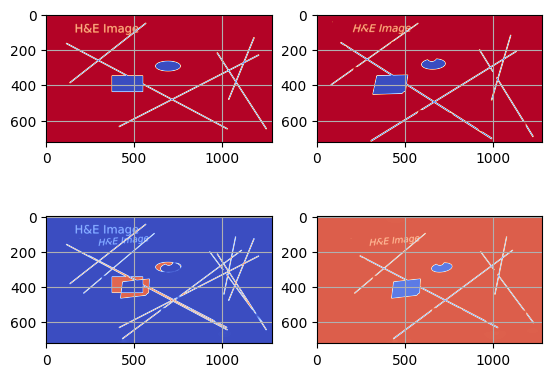

In [170]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-simple-1.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

numiter=10
result = ird.similarity(im0, im1, numiter=numiter)

#print(result)
# Ensure 'result' is a dictionary and contains 'timg'
if not isinstance(result, dict):
    raise ValueError("Expected 'result' to be a dictionary.")
assert "timg" in result, "'timg' not found in result dictionary"
#assert "success" in result
# Maybe we don't want to show plots all the time
if os.environ.get("IMSHOW", "yes") == "yes":
    ird.imshow(im0, im1, 
               result['timg']
               
               )
    plt.show()

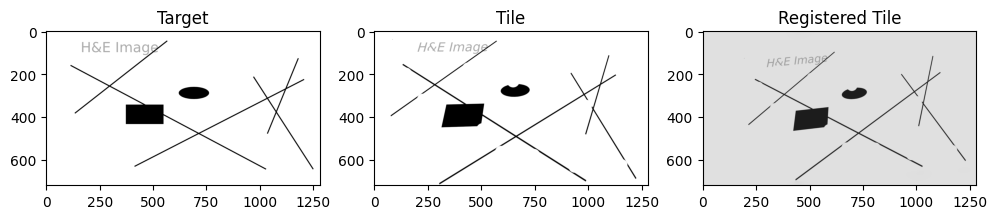

In [171]:
def load_and_convert_images(basedir, target_img_name, tile_img_name):
    # Load images
    target_img = imread(os.path.join(basedir, target_img_name), mode="F")
    tile_img = imread(os.path.join(basedir, tile_img_name), mode="F")
    # Normalize the images if using 'L' mode to ensure they are in a similar scale as when using as_gray=True
    target_img = target_img.astype(np.float32) / 255
    tile_img = tile_img.astype(np.float32) / 255

    # Convert images to grayscale if they are not already
    if target_img.ndim == 3:
        target_img = target_img.mean(axis=2)
    if tile_img.ndim == 3:
        tile_img = tile_img.mean(axis=2)

    return target_img, tile_img

def register_images(target_img, tile_img, numiter=3):
    # Direct call to imreg_dft.similarity
    result = ird.similarity(target_img, tile_img, numiter=numiter)

    # Check if result contains 'timg'
    assert "timg" in result, "'timg' not found in result dictionary"
    
    # Optionally, visualize the result
    if os.environ.get("IMSHOW", "yes") == "yes":
        plt.figure(figsize=(12, 6))
        plt.subplot(131)
        plt.imshow(target_img, cmap='gray')
        plt.title('Target')
        plt.subplot(132)
        plt.imshow(tile_img, cmap='gray')
        plt.title('Tile')
        plt.subplot(133)
        plt.imshow(result['timg'], cmap='gray')
        plt.title('Registered Tile')
        plt.show()

    return result

basedir = '/Users/linh/Downloads/example-toy-images-for-registration/data'
target_img, tile_img = load_and_convert_images(basedir, "image-target-image.png", "tiled/image-simple-1.png")

result = register_images(target_img, tile_img, numiter=10)

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (720, 1280, 4)


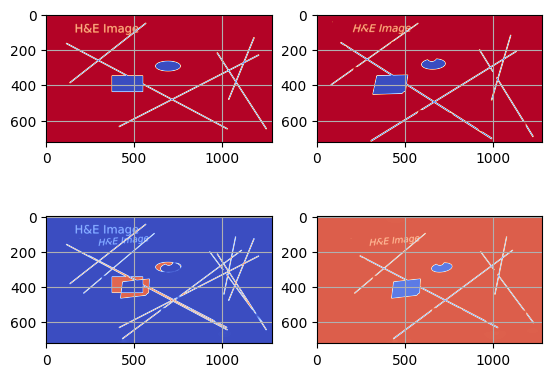

In [172]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-simple-1.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

numiter=10
#result = ird.similarity(im0, im1, numiter=numiter)
result = register(im0, im1, method="similarity", numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(im0, im1, result['timg'])
        plt.show()

### The Registration process for image-harder-1

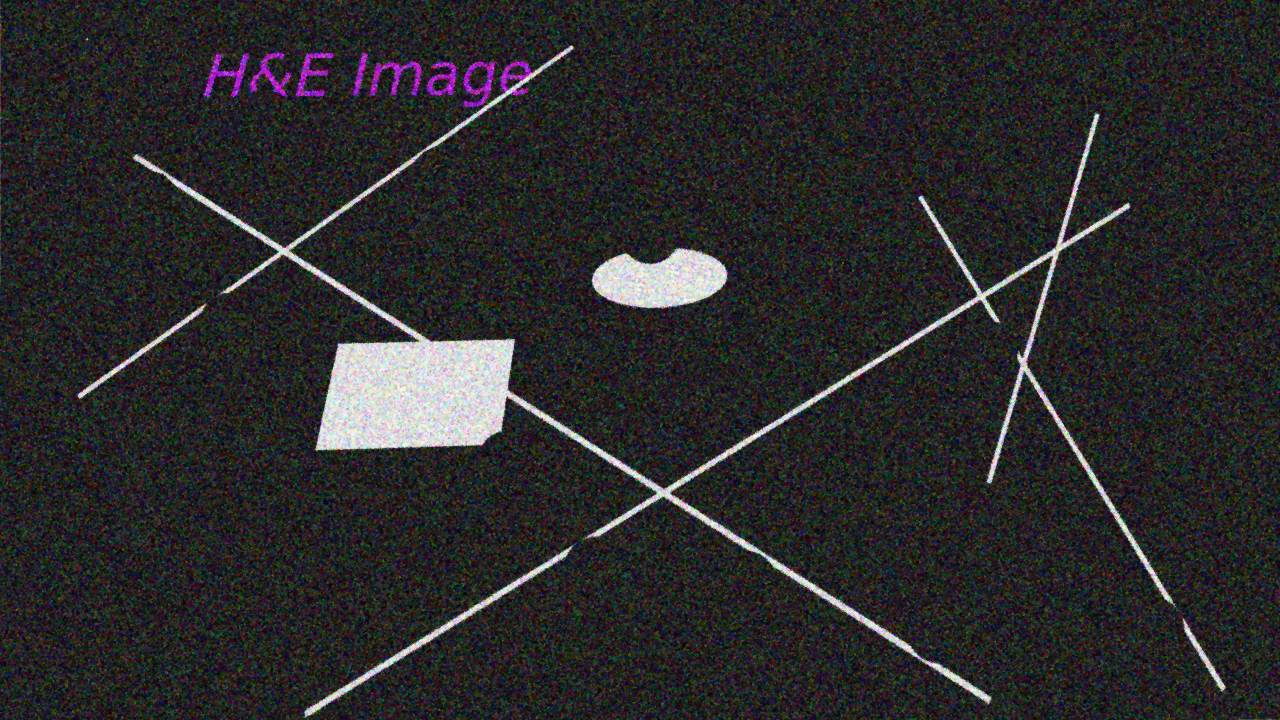

In [173]:
h1 = Image.open(os.path.join(basedir, "tiled/image-harder-1.png"))
display(h1)

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (720, 1280, 4)


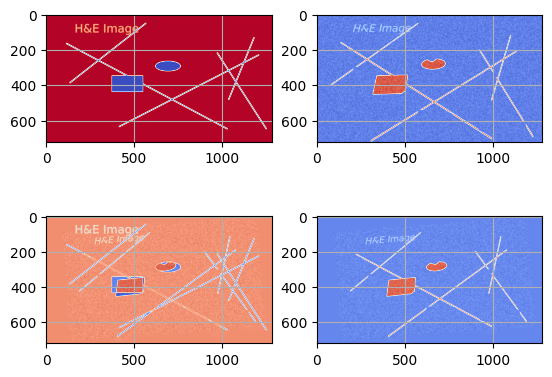

In [174]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-harder-1.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

result = register(im0, im1, method="similarity", numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(im0, im1, result['timg'])
        plt.show()

### It works but not perfect!!!!!

### The Registration process for image-harder-2

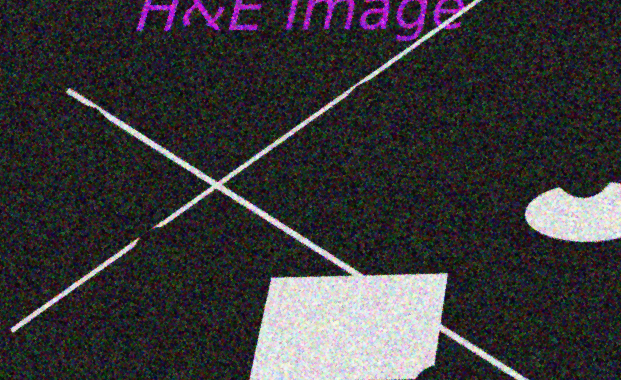

In [175]:
h2 = Image.open(os.path.join(basedir, "tiled/image-harder-1-1.png"))
display(h2)

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (380, 621, 3)


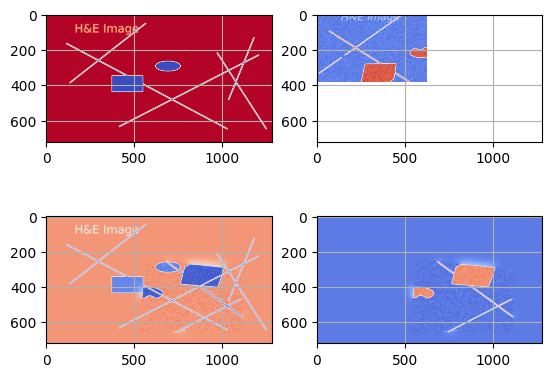

In [176]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-harder-1-1.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

# Normalize images to [0, 1] for resizing
im0_norm = im0 / 255
im1_norm = im1 / 255

# Resize the tiled image to match the target image's shape
im1_resized = resize(im1_norm, im0_norm.shape, anti_aliasing=True)

result = register(im0_norm, im1_resized, method="similarity", numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(im0, im1, result['timg'])
        plt.show()

#### The algorithm can't not find the registered region out to process registration!!!!!!!!!
#### I will fix it at the end of the JupyterLab

### The registration process for image-simple-1-1

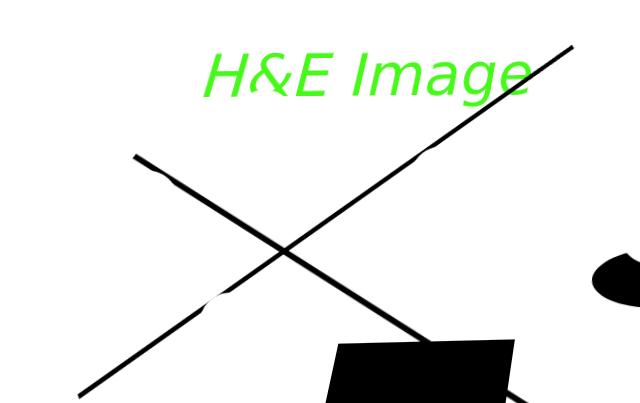

In [177]:
s11 = Image.open(os.path.join(basedir, "tiled/image-simple-1-1.png"))
display(s11)

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (403, 640, 4)


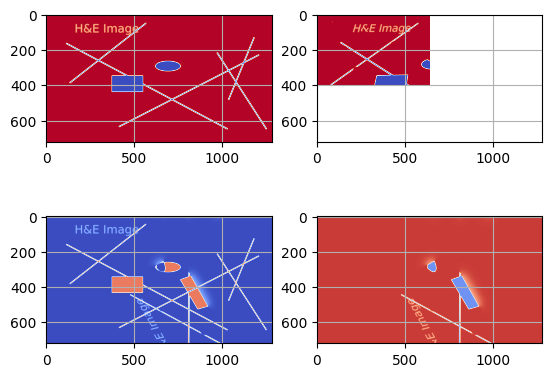

In [178]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-simple-1-1.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

# Normalize images to [0, 1] for resizing
im0_norm = im0 / 255
im1_norm = im1 / 255

# Resize the tiled image to match the target image's shape
im1_resized = resize(im1_norm, im0_norm.shape, anti_aliasing=True)

numiter=20
result = register(im0_norm, im1_resized, method="similarity",numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(im0, im1, result['timg'])
        plt.show()

#### The algorithm can't not find the registered region out to process registration!!!!!!!!!
#### I will fix it at the end of the JupyterLab

### The registration process for image-simple-1-2

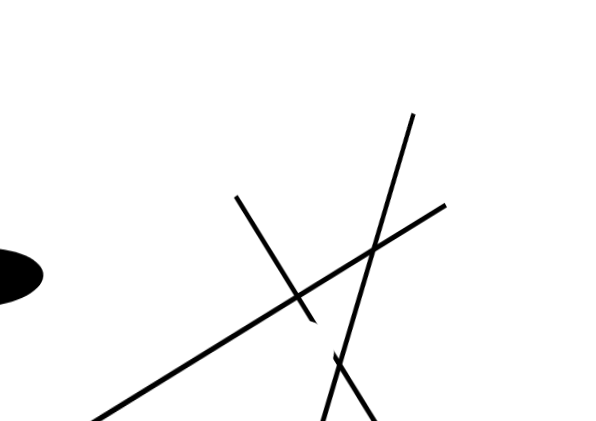

In [179]:
s12 = Image.open(os.path.join(basedir, "tiled/image-simple-1-2.png"))
display(s12)

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (421, 596, 3)


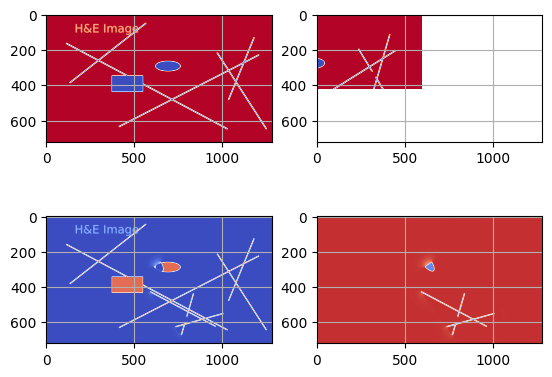

In [180]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-simple-1-2.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

# Normalize images to [0, 1] for resizing
im0_norm = im0 / 255
im1_norm = im1 / 255

# Resize the tiled image to match the target image's shape
im1_resized = resize(im1_norm, im0_norm.shape, anti_aliasing=True)

numiter=20
# Define constraints
constraints = {
    'scale': (0.5, 2.0),
    'angle': (-45, 45)
}
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
result = register(im0_norm, im1_resized, method="similarity", constraints=constraints, numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(im0, im1, result['timg'])
        plt.show()

#### The algorithm can't not find the registered region out to process registration!!!!!!!!!
#### I will fix it at the end of the JupyterLab

### The registration process for the image-simple-1-3

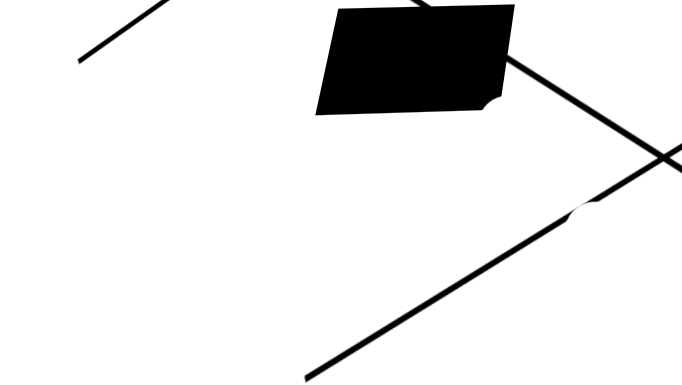

In [182]:
s13 = Image.open(os.path.join(basedir, "tiled/image-simple-1-3.png"))
display(s13)

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (385, 682, 3)


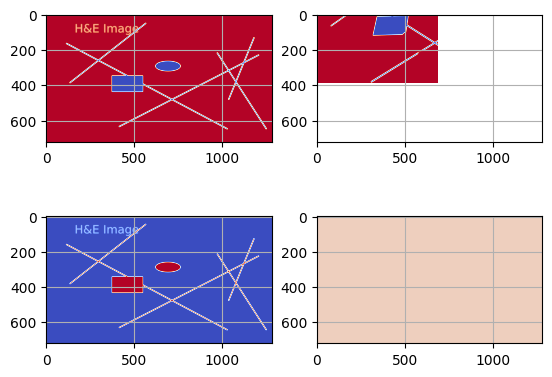

In [183]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-simple-1-3.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

# Normalize images to [0, 1] for resizing
im0_norm = im0 / 255
im1_norm = im1 / 255

# Resize the tiled image to match the target image's shape
im1_resized = resize(im1_norm, im0_norm.shape, anti_aliasing=True)

numiter=20
# Define constraints
constraints = {
    'scale': (0.5, 2.0),
    'angle': (-45, 45)
}
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
result = register(im0_norm, im1_resized, method="similarity", constraints=constraints, numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(im0, im1, result['timg'])
        plt.show()

#### The algorithm can't not find the registered region out to process registration!!!!!!!!!
#### I will fix it at the end of the JupyterLab

### The registration process for the image-simple-1-4

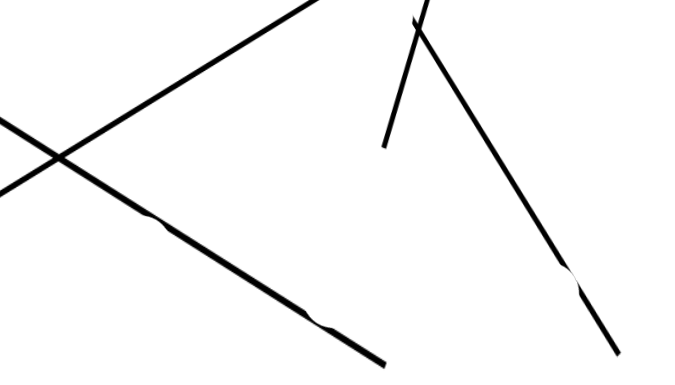

In [184]:
s14 = Image.open(os.path.join(basedir, "tiled/image-simple-1-4.png"))
display(s14)

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (385, 675, 4)


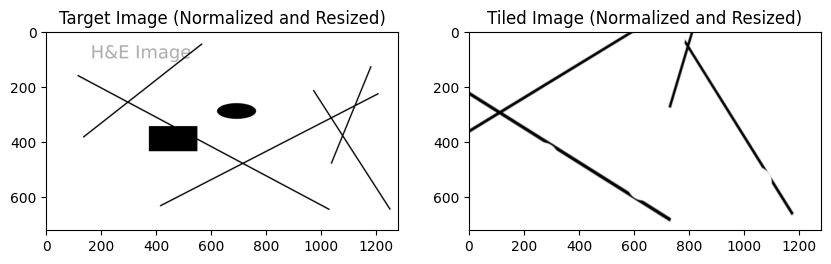

ValueError: Images are not compatible. Scale change 0.46202 too big to be true.

In [190]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-simple-1-4.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

# Normalize images to [0, 1] for resizing
im0_norm = im0 / 255
im1_norm = im1 / 255

# Resize the tiled image to match the target image's shape
im1_resized = resize(im1_norm, im0_norm.shape, anti_aliasing=True)

# Visualization of preprocessed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im0_norm, cmap='gray')
plt.title("Target Image (Normalized and Resized)")
plt.subplot(1, 2, 2)
plt.imshow(im1_resized, cmap='gray')
plt.title("Tiled Image (Normalized and Resized)")
plt.show()


numiter=20
# Define constraints
constraints = {
    'scale': (0.1, 5.0),
    'angle': (-45, 45)
}
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
result = register(im0_norm, im1_resized, method="similarity", constraints=constraints, numiter=numiter)
#print(result)
# Visualization after registration, if 'timg' is in the result
if "timg" in result:
    plt.figure(figsize=(10, 5))
    plt.imshow(result['timg'], cmap='gray')
    plt.title("Registered Tiled Image")
    plt.show()

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(im0, im1, result['timg'])
        plt.show()

### Without finding an approximate region, which should focus on initializing the registration process, the algorithm doesn't work with an error!!!!!!!

## Now, to overcome bad registration outcomes, we need to find approximate regions first and process the registration

In [4]:
def show_section(
        img: np.ndarray,
        title: str = "",
    ):
        """
        Displays a chosen section

        img: 2D numpy.ndarray type float32
        title: figure title
        """
        img = img.astype(np.float32)
        img = np.clip(
            img,
            a_min=np.mean(img) - 5 * np.std(img),
            a_max=np.mean(img) + 5 * np.std(img),
        )
        eq_img = equalize_adapthist(img / img.max())
        plt.imshow(eq_img)
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.title(title)
        plt.show()

In [164]:
from skimage.color import rgb2gray
from skimage.io import imread
import cv2
import numpy as np

def find_origin_1(target_file: str, tile_file: str, x_start: int, y_start: int, border: float = 0.5, method="similarity"):
     # Load images
    tile_color = imread(tile_file)
    target_color = imread(target_file)

    # Check if images have four channels (RGBA), and if so, drop the alpha channel
    if tile_color.shape[-1] == 4:
        tile_color = tile_color[:, :, :3]
    if target_color.shape[-1] == 4:
        target_color = target_color[:, :, :3]

    # Convert to grayscale
    tile = rgb2gray(tile_color)
    target = rgb2gray(target_color)

    y_border = int(tile.shape[0] * border)
    x_border = int(tile.shape[1] * border)
    tile_with_borders = cv2.copyMakeBorder(tile, y_border, y_border, x_border, x_border, cv2.BORDER_CONSTANT, value=0)
    
    # Calculate new positions considering borders
    x0, y0, x1, y1 = calculate_new_positions(x_start, y_start, x_border, y_border, target.shape, tile_with_borders.shape)

    target_section = target[y0:y1, x0:x1]
    # Calculate the amount of padding needed to make the target_section
    # the same size as tile_with_borders (if that's the goal)
    top = (tile_with_borders.shape[0] - target_section.shape[0]) // 2
    bottom = tile_with_borders.shape[0] - target_section.shape[0] - top
    left = (tile_with_borders.shape[1] - target_section.shape[1]) // 2
    right = tile_with_borders.shape[1] - target_section.shape[1] - left

    # Ensure non-negative values for padding (optional safety check)
    top = max(0, top)
    bottom = max(0, bottom)
    left = max(0, left)
    right = max(0, right)
    target_with_borders = cv2.copyMakeBorder(target_section, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0)

    # Now both 'tile_with_borders' and 'target_with_borders' should be compatible for shape comparisons
    assert tile_with_borders.shape == target_with_borders.shape, "Shapes do not match"

    # Visualization and registration logic goes here
    #show_section(target_color)
    #show_section(tile_color)
    show_section(target)
    show_section(tile)
    show_section(target_with_borders, "Approximate region of the target image should be registered")
    show_section(tile_with_borders, "The tile image with borders")
    # Note: Ensure 'register' function can handle grayscale images and adjust parameters as needed
    return target_with_borders, tile_with_borders

def calculate_new_positions(x_start, y_start, x_border, y_border, target_shape, tile_shape_with_borders):
    # Ensure starting positions are not negative after subtracting borders
    x0 = max(0, x_start - x_border)
    y0 = max(0, y_start - y_border)
    
    # Calculate ending positions based on tile size with borders
    x1 = x0 + tile_shape_with_borders[1]  # width
    y1 = y0 + tile_shape_with_borders[0]  # height

    # Ensure ending positions do not exceed target image dimensions
    x1 = min(x1, target_shape[1])  # target width
    y1 = min(y1, target_shape[0])  # target height
    
    return x0, y0, x1, y1


In [116]:
def find_origin(target_file: str, tile_file: str, x_start: int, y_start: int, x_end: int, y_end: int, border: float = 0.5, method="similarity"):
     # Load images
    tile_color = imread(tile_file)
    target_color = imread(target_file)

    # Check if images have four channels (RGBA), and if so, drop the alpha channel
    if tile_color.shape[-1] == 4:
        tile_color = tile_color[:, :, :3]
    if target_color.shape[-1] == 4:
        target_color = target_color[:, :, :3]

    # Convert to grayscale
    tile = rgb2gray(tile_color)
    target = rgb2gray(target_color)

    # Calculate borders for tile image
    y_border = int(tile.shape[0] * border)
    x_border = int(tile.shape[1] * border)
    tile_with_borders = cv2.copyMakeBorder(tile, y_border, y_border, x_border, x_border, cv2.BORDER_CONSTANT, value=0)
    
    # Adjust x_end and y_end considering borders
    x_end_adj = x_end + x_border * 2
    y_end_adj = y_end + y_border * 2

    # Select the target region based on start and end coordinates
    target_section = target[y_start:y_end_adj, x_start:x_end_adj]
    target_with_borders = cv2.copyMakeBorder(target_section, y_border, y_border, x_border, x_border, cv2.BORDER_CONSTANT, value=0)
    print("target_with_borders shape:", target_with_borders.shape)
    print("tile_with_borders shape:", tile_with_borders.shape)
    # Visualization and registration logic goes here
    #show_section(target_color)
    #show_section(tile_color)
    show_section(target)
    show_section(tile)
    show_section(target_section, "Approximate region of the target image should be registered")
    show_section(tile_with_borders, "The tile image with borders")
    # Note: Ensure 'register' function can handle grayscale images and adjust parameters as needed
    return target_section, tile_with_borders


### Now registration again for the image-simple-1-1

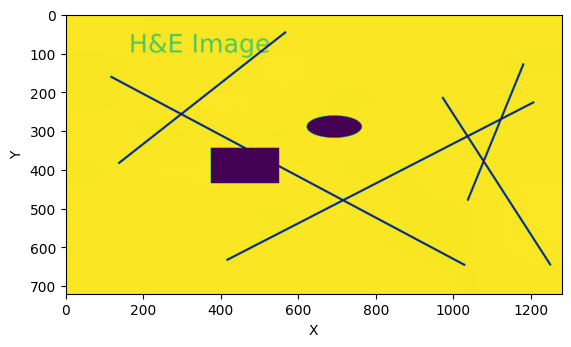

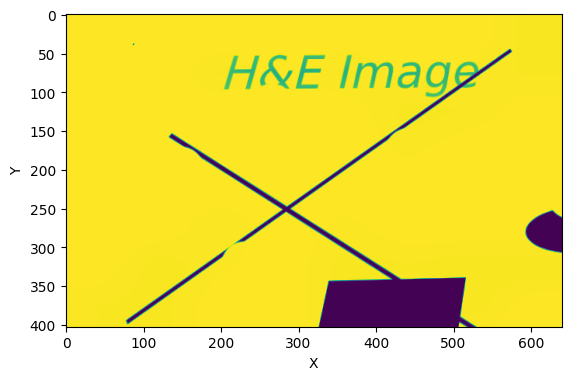

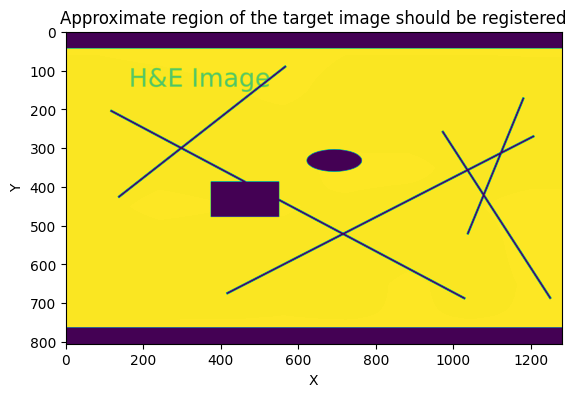

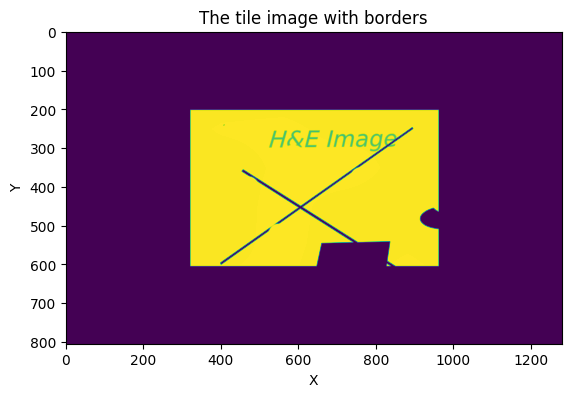

In [173]:
target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-1.png"
x_start = 0
x_end = 550
y_start = 0
y_end = 410
border = 0.5
target_section, tile_with_borders = find_origin_1(target_file=target_file, 
            tile_file=tile_file, 
            x_start=x_start, 
            #x_end=x_end,
            y_start=y_start, 
            #y_end=y_end
            )

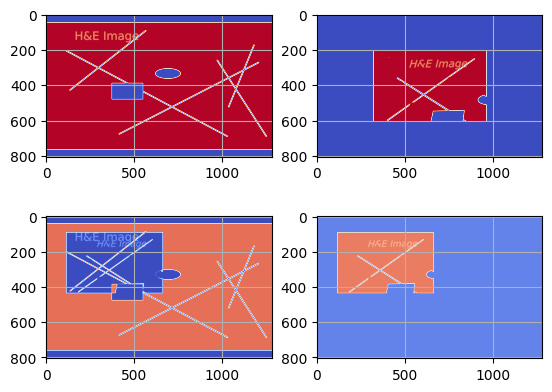

In [178]:
numiter=20
# Define constraints
constraints = {
    'scale': (0.2, 5.0),
    'angle': (-45, 45)
}

# Example logic to ensure both images have the same shape for registration
if target_section.shape != tile_with_borders.shape:
    # Logic to adjust shapes
    # This could involve resizing or further border adjustments
    pass

# Proceed with registration only if the shapes match
if target_section.shape == tile_with_borders.shape:
    result = register(target_section, tile_with_borders, method="similarity", numiter=numiter, #constraints=constraints
                   )
    #result = ird.similarity(target_section, tile_with_borders)
else:
    print("Shape mismatch, registration skipped.")
    

 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
# result = register(target_section, tile_with_borders, method="similarity", #constraints=constraints, 
#                    numiter=numiter)
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
#result = register(im0_norm, im1_resized, method="similarity", numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(target_section, tile_with_borders, result['timg'])
        plt.show()


# plt.figure(figsize=(12, 4))
# plt.subplot(1, 3, 1)
# plt.imshow(target_section, cmap='gray')
# plt.title('Target with Borders')
# plt.subplot(1, 3, 2)
# plt.imshow(tile_with_borders, cmap='gray')
# plt.title('Tile with Borders')
# plt.subplot(1, 3, 3)
# # Ensure result['timg'] is properly aligned before visualization
# plt.imshow(result['timg'], cmap='gray')
# plt.title('Transformed Tile')
# plt.show()

### Now registration again for the image-simple-1-2

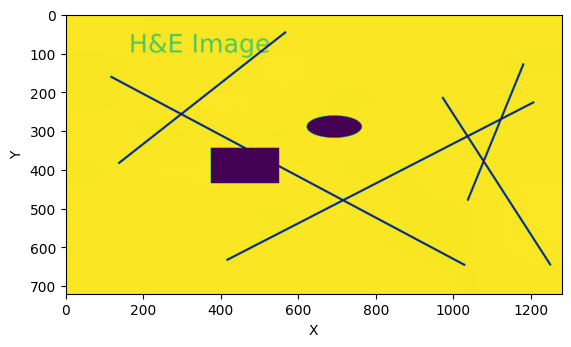

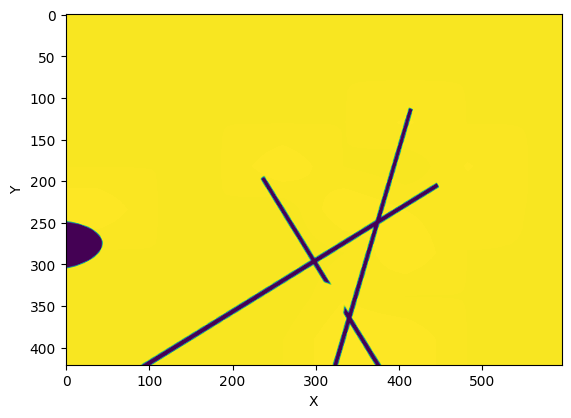

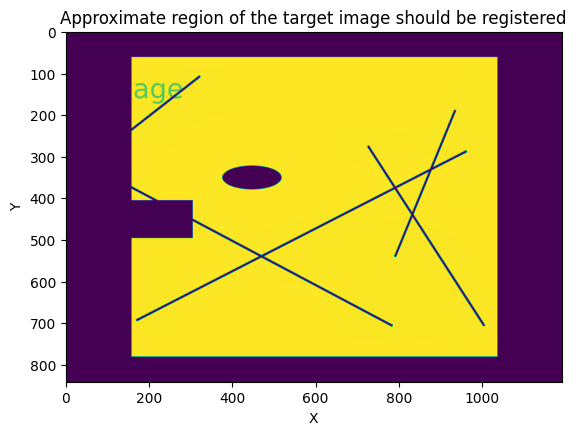

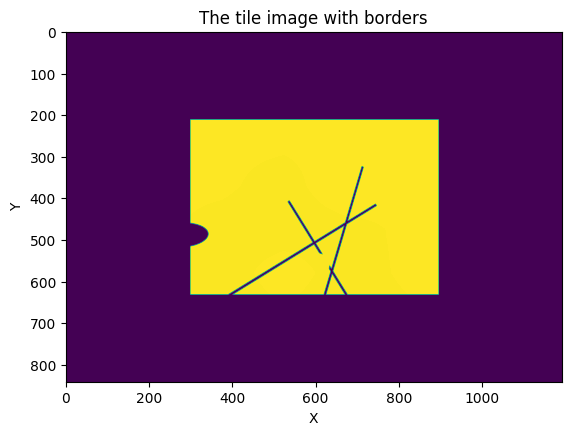

In [219]:
target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-2.png"
x_start = 700
#x_end = 1400
y_start = 100
#y_end = 20
border = 0.5
target_with_borders, tile_with_borders = find_origin_1(target_file=target_file, 
            tile_file=tile_file, 
            x_start=x_start, 
            #x_end=x_end, 
            #y_end=y_end,
            y_start=y_start
            )

Shape mismatch, registration skipped.


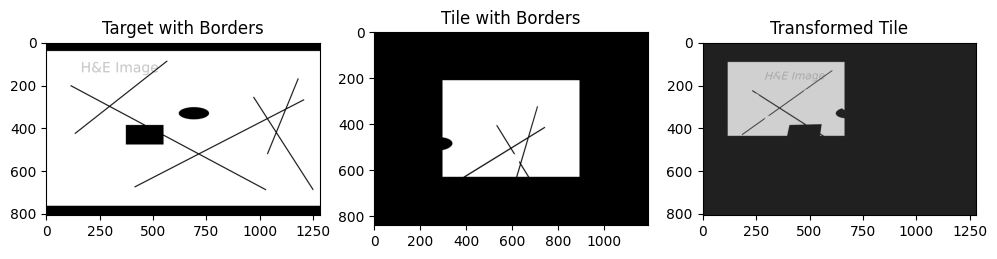

In [220]:

numiter=20
# Define constraints
constraints = {
    'scale': (0.2, 5.0),
    'angle': (-45, 45)
}
# Example logic to ensure both images have the same shape for registration
if target_section.shape != tile_with_borders.shape:
    # Logic to adjust shapes
    # This could involve resizing or further border adjustments
    pass

# Proceed with registration only if the shapes match
if target_section.shape == tile_with_borders.shape:
    result = register(target_section, tile_with_borders, method="translation", numiter=numiter, constraints=constraints
                  )
    #result = ird.similarity(target_section, tile_with_borders)
else:
    print("Shape mismatch, registration skipped.")
    

 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
# result = register(target_with_borders, tile_with_borders, method="similarity", #constraints=constraints, 
#                   numiter=numiter)
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
#result = register(im0_norm, im1_resized, method="similarity", numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
# if "timg" in result:
#     # Visualize the result if necessary
#     if os.environ.get("IMSHOW", "yes") == "yes":
#         ird.imshow(target_section, tile_with_borders, result['timg'])
#         plt.show()


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(target_section, cmap='gray')
plt.title('Target with Borders')
plt.subplot(1, 3, 2)
plt.imshow(tile_with_borders, cmap='gray')
plt.title('Tile with Borders')
plt.subplot(1, 3, 3)
# Ensure result['timg'] is properly aligned before visualization
plt.imshow(result['timg'], cmap='gray')
plt.title('Transformed Tile')
plt.show()

### Now registration again for the image-simple-1-3

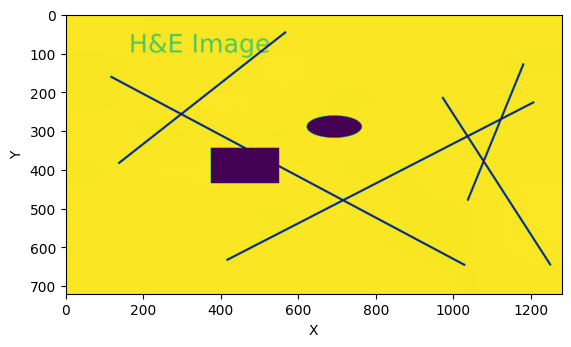

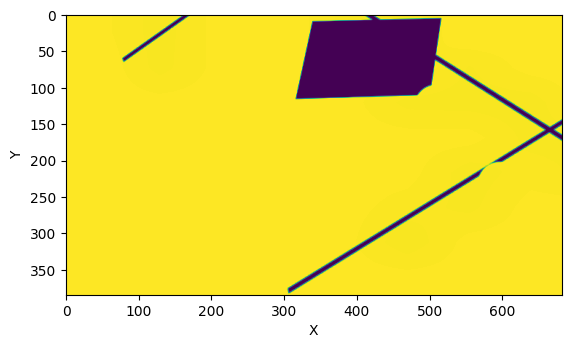

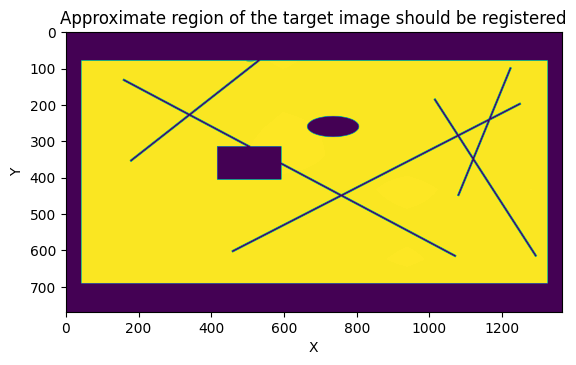

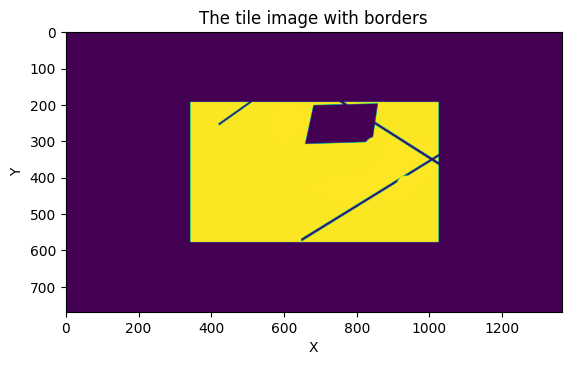

In [263]:
target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png"
x_start = 170
#x_end = 90
y_start = 300
#y_end = 340
border = 0.5
target_with_borders, tile_with_borders = find_origin_1(target_file=target_file, 
            tile_file=tile_file, 
            x_start=x_start, 
            #x_end=x_end, 
            y_start=y_start,
            #y_end=y_end
            )

Shape mismatch, registration skipped.


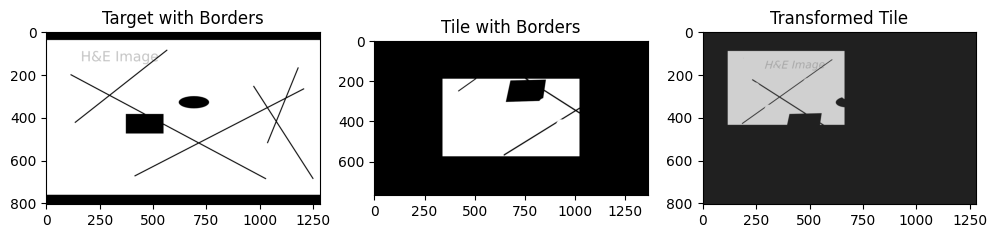

In [252]:
numiter=20
# Define constraints
constraints = {
    'scale': (0.2, 5.0),
    'angle': (-45, 45)
}
# Example logic to ensure both images have the same shape for registration
if target_section.shape != tile_with_borders.shape:
    # Logic to adjust shapes
    # This could involve resizing or further border adjustments
    pass

# Proceed with registration only if the shapes match
if target_section.shape == tile_with_borders.shape:
    # result = register(target_section, tile_with_borders, method="translation", #numiter=numiter, #constraints=constraints
    #               )
    result = ird.similarity(target_section, tile_with_borders)
else:
    print("Shape mismatch, registration skipped.")
    

 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
# result = register(target_with_borders, tile_with_borders, method="similarity", #constraints=constraints, 
#                   numiter=numiter)
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
#result = register(im0_norm, im1_resized, method="similarity", numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
# if "timg" in result:
#     # Visualize the result if necessary
#     if os.environ.get("IMSHOW", "yes") == "yes":
#         ird.imshow(target_section, tile_with_borders, result['timg'])
#         plt.show()


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(target_section, cmap='gray')
plt.title('Target with Borders')
plt.subplot(1, 3, 2)
plt.imshow(tile_with_borders, cmap='gray')
plt.title('Tile with Borders')
plt.subplot(1, 3, 3)
# Ensure result['timg'] is properly aligned before visualization
plt.imshow(result['timg'], cmap='gray')
plt.title('Transformed Tile')
plt.show()

### Now registration again for the image-simple-1-4

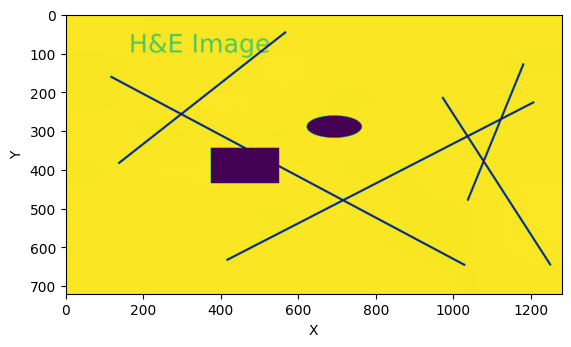

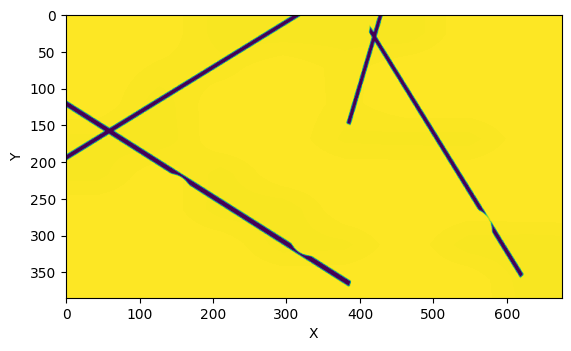

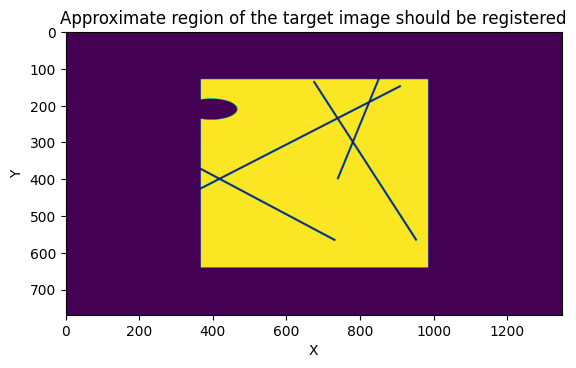

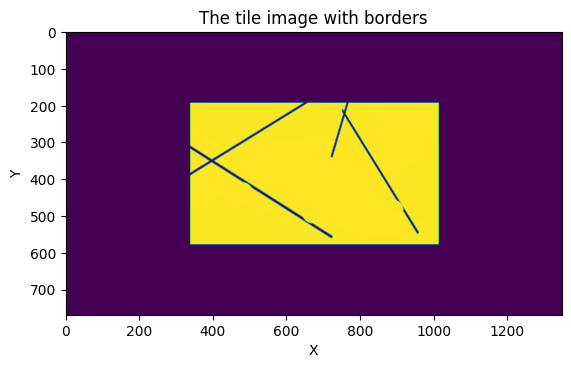

In [165]:
target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-4.png"
x_start = 1000
y_start = 400
border = 0.5
target_with_borders, tile_with_borders = find_origin_1(target_file=target_file, 
            tile_file=tile_file, 
            x_start=x_start, 
            y_start=y_start
            )

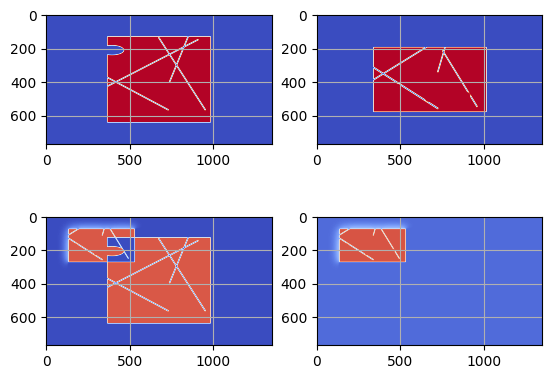

In [166]:
numiter=20
# Define constraints
constraints = {
    'scale': (0.2, 5.0),
    'angle': (-45, 45)
}
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
result = register(target_with_borders, tile_with_borders, method="similarity", constraints=constraints, numiter=numiter)
 # Adjust the scale range as needed
#result = ird.similarity(img0, img1, constraints=constraints, numiter=numiter)
#result = register(im0_norm, im1_resized, method="similarity", numiter=numiter)
#print(result)

# Now 'result' is a dictionary, so we don't need to check if it's a dictionary.
# But we can still check if 'timg' is in result if we need to use 'timg'.
if "timg" in result:
    # Visualize the result if necessary
    if os.environ.get("IMSHOW", "yes") == "yes":
        ird.imshow(target_with_borders, tile_with_borders, result['timg'])
        plt.show()

#### Now the registration is successful!!!!!!!!!!!!

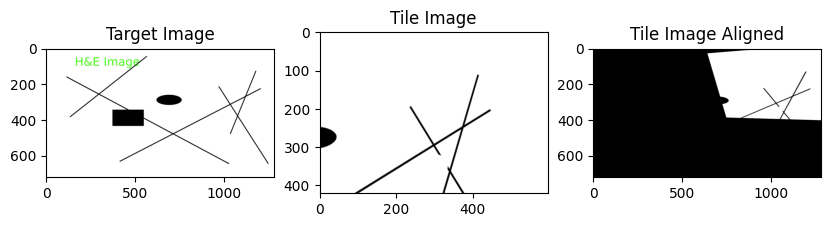

In [242]:
import numpy as np
import cv2
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

def find_origin_elastic(target_file, tile_file, method="ORB"):
    # Load images
    target_img = imread(target_file)
    tile_img = imread(tile_file)
    
    # Ensure images are in RGB
    if target_img.shape[-1] == 4:  # Remove alpha channel if present
        target_img = target_img[..., :3]
    if tile_img.shape[-1] == 4:  # Remove alpha channel if present
        tile_img = tile_img[..., :3]

    # Convert images to grayscale
    target_gray = cv2.cvtColor(target_img, cv2.COLOR_RGB2GRAY)
    tile_gray = cv2.cvtColor(tile_img, cv2.COLOR_RGB2GRAY)

    # Initialize feature detector
    if method == "ORB":
        detector = cv2.ORB_create()
    elif method == "SIFT":
        detector = cv2.SIFT_create()
    else:
        raise ValueError(f"Unsupported method: {method}")

    # Detect keypoints and descriptors
    keypoints_target, descriptors_target = detector.detectAndCompute(target_gray, None)
    keypoints_tile, descriptors_tile = detector.detectAndCompute(tile_gray, None)

    # Match descriptors
    if method == "ORB":
        # Use BFMatcher for binary descriptors
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    else:
        # FLANN matcher for SIFT/SURF (floating-point descriptors)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)

    matches = matcher.match(descriptors_target, descriptors_tile)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract location of matched keypoints
    points_target = np.zeros((len(matches), 2), dtype=np.float32)
    points_tile = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points_target[i, :] = keypoints_target[match.queryIdx].pt
        points_tile[i, :] = keypoints_tile[match.trainIdx].pt

    # Find homography
    H, _ = cv2.findHomography(points_tile, points_target, cv2.RANSAC)

    # Use homography to warp the tile image to the target image
    height, width = target_gray.shape
    tile_aligned = cv2.warpPerspective(tile_img, H, (width, height))

    return target_img, tile_img, tile_aligned


# Example usage
target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-2.png"
target_img, tile_img, tile_aligned = find_origin_elastic(target_file, tile_file)



plt.figure(figsize=(10, 5))
plt.subplot(1,3, 1)
plt.imshow(target_img)
plt.title('Target Image')
plt.subplot(1, 3, 2)
plt.imshow(tile_img)
plt.title('Tile Image')
plt.subplot(1, 3, 3)
plt.imshow(tile_aligned)
plt.title('Tile Image Aligned')
plt.show()


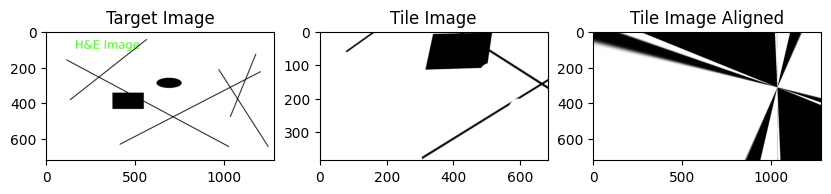

In [244]:
target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png"
target_img, tile_img, tile_aligned = find_origin_elastic(target_file, tile_file, 
                                               method="SIFT"
                                               #method="ORB"
                                               )

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_img)
plt.title('Target Image')
plt.subplot(1, 3, 2)
plt.imshow(tile_img)
plt.title('Tile Image')
plt.subplot(1, 3, 3)
plt.imshow(tile_aligned)
plt.title('Tile Image Aligned')
plt.show()

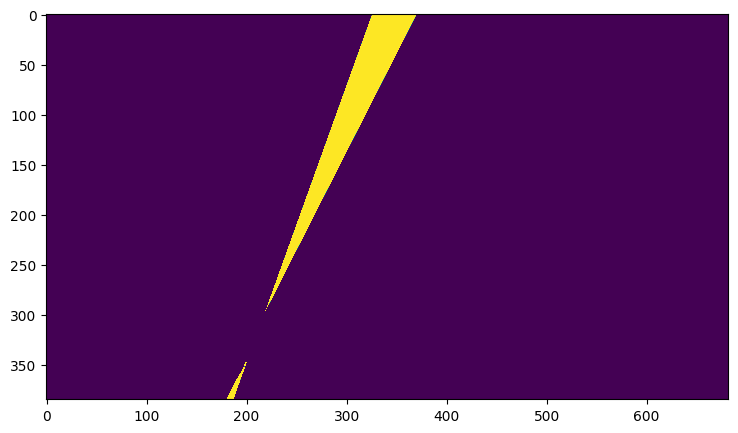

In [264]:
import numpy as np
from skimage import io, feature, transform, filters, color
from skimage.feature import SIFT
from skimage.transform import ProjectiveTransform, warp
from skimage.feature import match_descriptors
from skimage.measure import ransac


target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png"
# Load images
tiled_image = io.imread(tile_file)
target_image = io.imread(target_file)

# Resize the larger image (target_image) to a smaller size
if target_image.shape > tiled_image.shape:
    scale_factor = min(tiled_image.shape[0] / target_image.shape[0], tiled_image.shape[1] / target_image.shape[1])
    target_height = int(target_image.shape[0] * scale_factor)
    target_width = int(target_image.shape[1] * scale_factor)
    target_image = transform.resize(target_image, (target_height, target_width), anti_aliasing=True)

# Convert images to grayscale
tiled_image = color.rgb2gray(tiled_image)
target_image = color.rgb2gray(target_image)

# Apply preprocessing steps (e.g., Gaussian blur)
tiled_image_blur = filters.gaussian(tiled_image, sigma=1)
target_image_blur = filters.gaussian(target_image, sigma=1)

# Initialize SIFT detector
sift = SIFT()

# Detect keypoints and extract descriptors for tiled image
sift.detect_and_extract(tiled_image_blur)
tiled_keypoints = sift.keypoints
tiled_descriptors = sift.descriptors

# Detect keypoints and extract descriptors for target image
sift.detect_and_extract(target_image_blur)
target_keypoints = sift.keypoints
target_descriptors = sift.descriptors

matches = feature.match_descriptors(tiled_descriptors, target_descriptors, cross_check=True)

# Estimate transformation model using RANSAC
if len(matches) > 0:
    src = np.array([tiled_keypoints[m[0]] for m in matches])
    dst = np.array([target_keypoints[m[1]] for m in matches])
    model, inliers = ransac((src, dst), ProjectiveTransform, min_samples=4, residual_threshold=2, max_trials=1000)

    # Apply transformation if a valid model was found
    if model is not None:
        # Apply the transformation to the tiled image
        registered_image = warp(tiled_image, model.inverse, mode='constant', preserve_range=True)
        # Visualization and further processing
        plt.figure(figsize=(10, 5))
        plt.imshow(registered_image)
        plt.show()
#display(registered_image)

# Save the registered image
#io.imsave('registered_image.jpg', registered_image)
# plt.figure(figsize=(10, 5))
# plt.imshow(registered_image)
# plt.show()

Not enough matches are found - 5/10


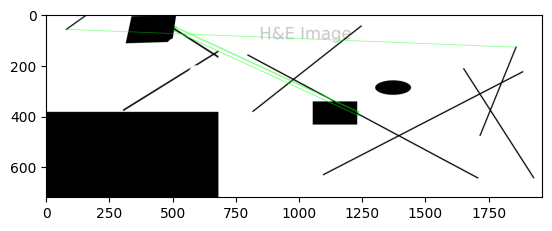

Homography could not be computed. Check the number of good matches.


In [266]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png"

# Load images
tile_img = cv2.imread(tile_file, cv2.IMREAD_GRAYSCALE)
target_img = cv2.imread(target_file, cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(tile_img, None)
kp2, des2 = sift.detectAndCompute(target_img, None)

# FLANN parameters and matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

# Matching descriptor vectors using FLANN matcher
matches = flann.knnMatch(des1, des2, k=2)

# Store all good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Compute the transformation matrix
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h, w = tile_img.shape
    pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, M)
    
    target_img = cv2.polylines(target_img, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

# Finally, draw the matches (for visualization)
draw_params = dict(matchColor=(0, 255, 0),
                   singlePointColor=None,
                   matchesMask=matchesMask,
                   flags=2)
result = cv2.drawMatches(tile_img, kp1, target_img, kp2, good, None, **draw_params)

plt.imshow(result, 'gray')
plt.show()

# Ensure that M is defined before trying to use it
if 'M' in locals():
    # Warp the tile image to the target image
    aligned_tile_img = cv2.warpPerspective(tile_img, M, (target_img.shape[1], target_img.shape[0]))

    plt.imshow(aligned_tile_img, 'gray')
    plt.title('Aligned Tile Image')
    plt.show()
else:
    print("Homography could not be computed. Check the number of good matches.")



Inliers: 7


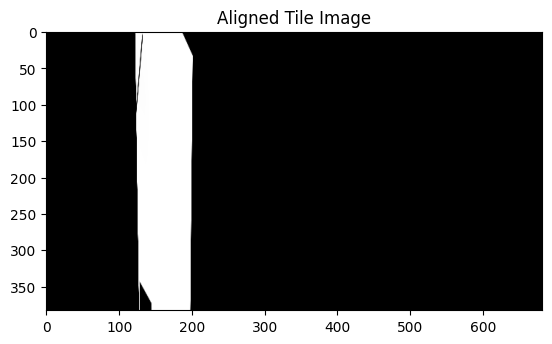

In [267]:
import numpy as np
from skimage import io, feature, transform, filters, color
from skimage.feature import SIFT
from skimage.transform import ProjectiveTransform, warp
from skimage.feature import match_descriptors
from skimage.measure import ransac
from skimage.exposure import equalize_adapthist
from skimage.feature import ORB, match_descriptors



target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png"
# Load images
tiled_image = io.imread(tile_file)
target_image = io.imread(target_file)

# Resize the larger image (target_image) to a smaller size
if target_image.shape > tiled_image.shape:
    scale_factor = min(tiled_image.shape[0] / target_image.shape[0], tiled_image.shape[1] / target_image.shape[1])
    target_height = int(target_image.shape[0] * scale_factor)
    target_width = int(target_image.shape[1] * scale_factor)
    target_image = transform.resize(target_image, (target_height, target_width), anti_aliasing=True)

# Convert images to grayscale
tile_img_gray = color.rgb2gray(tiled_image)
target_img_gray = color.rgb2gray(target_image)

# Preprocess images
tile_img_gray = equalize_adapthist(tile_img_gray)
target_img_gray = equalize_adapthist(target_img_gray)

# Initialize ORB detector
orb = ORB(n_keypoints=500, fast_threshold=0.05)

# Detect and extract features
orb.detect_and_extract(tile_img_gray)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(target_img_gray)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# Match features
matches = match_descriptors(descriptors1, descriptors2, cross_check=True)

# Select the keypoints from the source (tile) and target images
src = keypoints1[matches[:, 0]]
dst = keypoints2[matches[:, 1]]

# Perform RANSAC
model, inliers = ransac((src, dst), ProjectiveTransform, min_samples=4, residual_threshold=2)

print(f"Inliers: {np.sum(inliers)}")

# Warp tile image to target image using the estimated transformation model
tile_img_aligned = warp(tile_img_gray, model.inverse, output_shape=target_img_gray.shape)

plt.imshow(tile_img_aligned, cmap='gray')
plt.title('Aligned Tile Image')
plt.show()


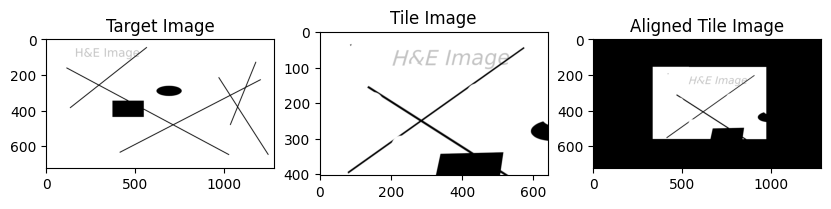

In [281]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt


target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-1.png"
# Read the images
tile_img_sitk = sitk.ReadImage(tile_file, sitk.sitkFloat32)
target_img_sitk = sitk.ReadImage(target_file, sitk.sitkFloat32)

# Initialize mutual information metric
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Initialize the transform (affine transform in this case)
transform = sitk.CenteredTransformInitializer(target_img_sitk, 
                                              tile_img_sitk, 
                                              sitk.AffineTransform(target_img_sitk.GetDimension()))

registration_method.SetInitialTransform(transform)

# Set optimizer (gradient descent in this case)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Set interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Execute the registration
final_transform = registration_method.Execute(sitk.Cast(target_img_sitk, sitk.sitkFloat32), 
                                              sitk.Cast(tile_img_sitk, sitk.sitkFloat32))

# Resample (warp) the moving image
tile_img_aligned_sitk = sitk.Resample(tile_img_sitk, target_img_sitk, final_transform, sitk.sitkLinear, 0.0, tile_img_sitk.GetPixelID())

# Convert SimpleITK image to numpy array for visualization
tile_img_aligned = sitk.GetArrayFromImage(tile_img_aligned_sitk)
target_img = sitk.GetArrayFromImage(target_img_sitk)
tile_image = sitk.GetArrayFromImage(tile_img_sitk)

# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_img, cmap='gray')
plt.title('Target Image')
plt.subplot(1, 3, 2)
plt.imshow(tile_image, cmap='gray')
plt.title('Tile Image')
plt.subplot(1, 3, 3)
plt.imshow(tile_img_aligned, cmap='gray')
plt.title('Aligned Tile Image')
plt.show()


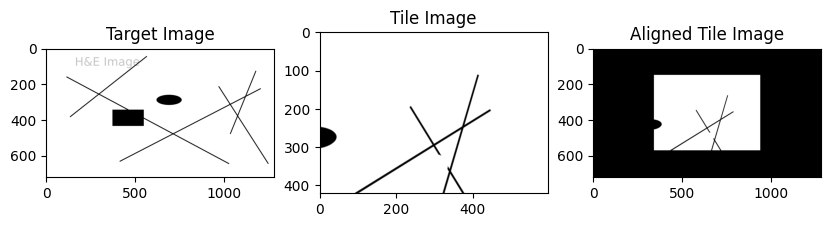

In [283]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt


target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-2.png"
# Read the images
tile_img_sitk = sitk.ReadImage(tile_file, sitk.sitkFloat32)
target_img_sitk = sitk.ReadImage(target_file, sitk.sitkFloat32)

# Initialize mutual information metric
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Initialize the transform (affine transform in this case)
transform = sitk.CenteredTransformInitializer(target_img_sitk, 
                                              tile_img_sitk, 
                                              sitk.AffineTransform(target_img_sitk.GetDimension()))

registration_method.SetInitialTransform(transform)

# Set optimizer (gradient descent in this case)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Set interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Execute the registration
final_transform = registration_method.Execute(sitk.Cast(target_img_sitk, sitk.sitkFloat32), 
                                              sitk.Cast(tile_img_sitk, sitk.sitkFloat32))

# Resample (warp) the moving image
tile_img_aligned_sitk = sitk.Resample(tile_img_sitk, target_img_sitk, final_transform, sitk.sitkLinear, 0.0, tile_img_sitk.GetPixelID())

# Convert SimpleITK image to numpy array for visualization
tile_img_aligned = sitk.GetArrayFromImage(tile_img_aligned_sitk)
target_img = sitk.GetArrayFromImage(target_img_sitk)
tile_img = sitk.GetArrayFromImage(tile_img_sitk)


# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_img, cmap='gray')
plt.title('Target Image')
plt.subplot(1, 3, 2)
plt.imshow(tile_img, cmap='gray')
plt.title('Tile Image')
plt.subplot(1, 3, 3)
plt.imshow(tile_img_aligned, cmap='gray')
plt.title('Aligned Tile Image')
plt.show()


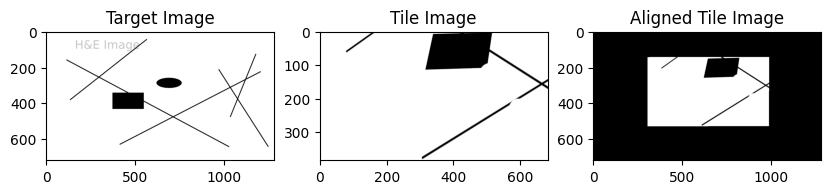

In [284]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt


target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png"
# Read the images
tile_img_sitk = sitk.ReadImage(tile_file, sitk.sitkFloat32)
target_img_sitk = sitk.ReadImage(target_file, sitk.sitkFloat32)

# Initialize mutual information metric
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Initialize the transform (affine transform in this case)
transform = sitk.CenteredTransformInitializer(target_img_sitk, 
                                              tile_img_sitk, 
                                              sitk.AffineTransform(target_img_sitk.GetDimension()))

registration_method.SetInitialTransform(transform)

# Set optimizer (gradient descent in this case)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Set interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Execute the registration
final_transform = registration_method.Execute(sitk.Cast(target_img_sitk, sitk.sitkFloat32), 
                                              sitk.Cast(tile_img_sitk, sitk.sitkFloat32))

# Resample (warp) the moving image
tile_img_aligned_sitk = sitk.Resample(tile_img_sitk, target_img_sitk, final_transform, sitk.sitkLinear, 0.0, tile_img_sitk.GetPixelID())

# Convert SimpleITK image to numpy array for visualization
tile_img_aligned = sitk.GetArrayFromImage(tile_img_aligned_sitk)
target_img = sitk.GetArrayFromImage(target_img_sitk)
tile_img = sitk.GetArrayFromImage(tile_img_sitk)


# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_img, cmap='gray')
plt.title('Target Image')
plt.subplot(1, 3, 2)
plt.imshow(tile_img, cmap='gray')
plt.title('Tile Image')
plt.subplot(1, 3, 3)
plt.imshow(tile_img_aligned, cmap='gray')
plt.title('Aligned Tile Image')
plt.show()


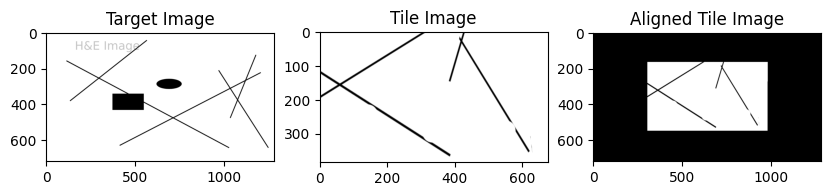

In [285]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt


target_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tile_file = "/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-4.png"
# Read the images
tile_img_sitk = sitk.ReadImage(tile_file, sitk.sitkFloat32)
target_img_sitk = sitk.ReadImage(target_file, sitk.sitkFloat32)

# Initialize mutual information metric
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Initialize the transform (affine transform in this case)
transform = sitk.CenteredTransformInitializer(target_img_sitk, 
                                              tile_img_sitk, 
                                              sitk.AffineTransform(target_img_sitk.GetDimension()))

registration_method.SetInitialTransform(transform)

# Set optimizer (gradient descent in this case)
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Set interpolator
registration_method.SetInterpolator(sitk.sitkLinear)

# Execute the registration
final_transform = registration_method.Execute(sitk.Cast(target_img_sitk, sitk.sitkFloat32), 
                                              sitk.Cast(tile_img_sitk, sitk.sitkFloat32))

# Resample (warp) the moving image
tile_img_aligned_sitk = sitk.Resample(tile_img_sitk, target_img_sitk, final_transform, sitk.sitkLinear, 0.0, tile_img_sitk.GetPixelID())

# Convert SimpleITK image to numpy array for visualization
tile_img_aligned = sitk.GetArrayFromImage(tile_img_aligned_sitk)
target_img = sitk.GetArrayFromImage(target_img_sitk)
tile_img = sitk.GetArrayFromImage(tile_img_sitk)


# Visualize the results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(target_img, cmap='gray')
plt.title('Target Image')
plt.subplot(1, 3, 2)
plt.imshow(tile_img, cmap='gray')
plt.title('Tile Image')
plt.subplot(1, 3, 3)
plt.imshow(tile_img_aligned, cmap='gray')
plt.title('Aligned Tile Image')
plt.show()


## Registration using the "Translation" method

Shape of the target image is (720, 1280, 3)
Shape of the tiled image is (720, 1280, 4)


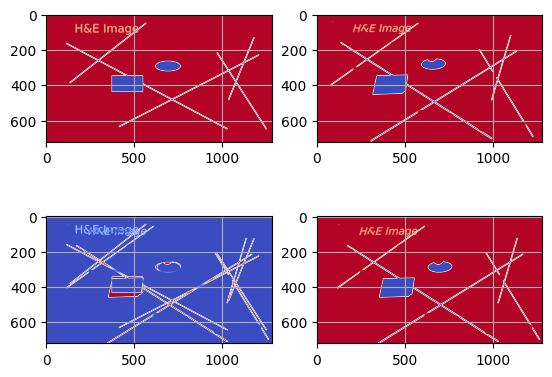

KeyError: 'success'

In [181]:
# the TEMPLATE
im0_color = imread(os.path.join(basedir, "image-target-image.png"))
print(f'Shape of the target image is {im0_color.shape}')
# the image to be transformed
im1_color = imread(os.path.join(basedir, "tiled/image-simple-1.png"))
print(f'Shape of the tiled image is {im1_color.shape}')

# Ensure both images have the same number of channels (3 in this case)
im0_color = im0_color[:, :, :3] if im0_color.shape[2] > 3 else im0_color
im1_color = im1_color[:, :, :3] if im1_color.shape[2] > 3 else im1_color

# Convert the images to grayscale
im0 = rgb2gray(im0_color)
im1 = rgb2gray(im1_color)

#result = ird.translation(im0, im1)
result = register(im0, im1, method="translation")
result['scale'] = result[0] 
tvec = result["tvec"].round(4)
# the Transformed IMaGe.
timg = ird.transform_img(im1, tvec=tvec)

# result = ird.similarity(im0, im1, numiter=3)

# assert "timg" in result
# Maybe we don't want to show plots all the time
if os.environ.get("IMSHOW", "yes") == "yes":
    import matplotlib.pyplot as plt
    ird.imshow(im0, im1, timg)
    plt.show()

print("Translation is {}, success rate {:.4g}"
      .format(tuple(tvec), result["success"]))

In [ ]:
from skimage.feature import ORB, match_descriptors
from skimage.color import rgb2gray
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage.io import imread
import os

# Assuming 'basedir' is set to your images directory
target_img_path = os.path.join(basedir, "image-target-image.png")
tiled_img_path = os.path.join(basedir, "tiled/image-simple-1-4.png")

# Load the images
target_img_color = imread(target_img_path)
tiled_img_color = imread(tiled_img_path)

# Remove the alpha channel if present
if target_img_color.shape[-1] == 4:
    target_img_color = target_img_color[..., :3]
if tiled_img_color.shape[-1] == 4:
    tiled_img_color = tiled_img_color[..., :3]

# Convert images to grayscale
target_img_gray = rgb2gray(target_img_color)
tiled_img_gray = rgb2gray(tiled_img_color)

# Initialize ORB detector
orb = ORB(n_keypoints=500, fast_threshold=0.05)

# Detect and extract features from the target image
orb.detect_and_extract(target_img_gray)  # Make sure 'target_img_gray' is a 2D array
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

# Detect and extract features from the tiled image
orb.detect_and_extract(tiled_img_gray)  # Make sure 'tiled_img_gray' is a 2D array
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

# Match the descriptors
matches = match_descriptors(descriptors1, descriptors2, cross_check=True)

# Visualize the matches
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.gray()

from skimage.feature import plot_matches
plot_matches(ax, target_img, tiled_img, keypoints1, keypoints2, matches[:50])
ax.axis('off')
ax.set_title("ORB Feature Matches")

plt.show()
